In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
from copy import deepcopy

In [3]:
from spacetime.spacetime import SpaceTime
from spacetime.simulate import Simulator
from spacetime.metrics import count_accuracy, adjacency_error
from spacetime.models import MLPEncoder, MLPDecoder
from spacetime.training import train, acyclicity
from spacetime.utils import arguments, spacetime_mutilator, graph_clipper
from spacetime.sampler import NodeData, GraphSampler

simulating a random 3-degree erdos-renyi dag with range (0.5, 2.0) (seed 0)


array([[ 0.        ,  0.        , -0.89683342,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.5281847 , -1.41814358],
       [ 0.        ,  0.        ,  0.        , -1.50015007,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.15554793],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

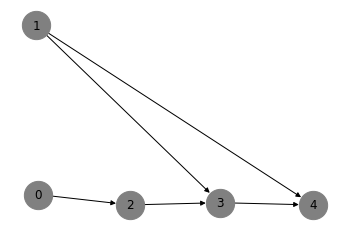

In [4]:
args = arguments(node_dict = {0:[0,1], 1:[2], 2:[3], 3:[4]})
args.data_sample_size=10000
args.noise_scale = 0.6
args.graph_type='erdos-renyi'
args.graph_sem_type='linear-gauss'
args.graph_linear_type='linear'
args.graph_degree = 3

# training hyperparameters
args.graph_threshold=0.3  # 0.3 is good 0.2 is error prune
args.tau_A=1e-8
args.ordered_graph=True
args.use_A_connect_loss=False
args.use_A_positiver_loss=False

args.seed=42
args.epochs=5
args.batch_size=100 # note: should be divisible by sample size otherwise throw an error
args.encoder_hidden=64
args.decoder_hidden=64

g = SpaceTime.from_spacelike([0,1,3,2,4], simulate=True,
                             degree=args.graph_degree, graph_type=args.graph_type, 
                             w_range=(0.5,2.0), force_positive=False, seed=0)
g.show_adj()
g.draw_graph()

In [5]:
col_plot_dict = {0:(4,3), 1:(4,1), 2:(3,2), 3:(2,0)}
mutilate = 3
observe = 4
latent = 1

In [6]:
g.data = Simulator.sem(graph=g.graph, n=args.data_sample_size, x_dims=args.x_dims, 
                       sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                       noise_scale=args.noise_scale, seed=args.seed)
train_loader, test_loader = g.torch_loader(g.data, args.batch_size)

simulating 10000 samples from a linear-gauss sem with linear causal effects


In [7]:
# n_trials = 1

# shd_trials = list()
# err_trials = list()
# kl_trials = list()
# nll_trials = list()
# elbo_trials = list()
# graph_trials = list()

# for trial in range(n_trials):
#     shd_train, err_train = list(), list()
#     kl_train, nll_train, elbo_train = list(), list(), list()
#     hA_train = list()
#     graph_train = list()

#     best_epoch = 0
#     best_ELBO, best_ELBO_graph = np.inf, None
#     best_KL, best_KL_graph = np.inf, None
#     best_NLL, best_NLL_graph = np.inf, None

#     # optimizer step on hyparameters
#     c_A = args.c_A
#     lambda_A = args.lambda_A
    
#     h_A_old, h_A_new = np.inf, torch.tensor(1.)
#     h_tol = args.h_tol
#     k_max_iter = int(args.k_max_iter)

#     #===================================
#     # load modules
#     #===================================
#     # add adjacency matrix A
#     num_nodes = args.data_variable_size
#     adj_A = np.zeros((num_nodes, num_nodes))

#     encoder = MLPEncoder(args.x_dims, args.encoder_hidden, int(args.z_dims), adj_A).double()
#     decoder = MLPDecoder(args.z_dims, args.x_dims, n_hid=args.decoder_hidden).double()

#     #===================================
#     # set up training parameters
#     #===================================
#     optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=args.lr)
#     scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay, gamma=args.gamma)

#     #===================================
#     # train model
#     #===================================
#     t_total = time.time()
#     for step_k in range(k_max_iter):
#         while c_A < 1e+20:
#             for epoch in range(args.epochs):
#                 ELBO, KL, NLL, origin_A = train(lambda_A, c_A, optimizer, scheduler, 
#                                                 encoder, decoder, train_loader, args)
#                 graph_clone, graph_full, graph = graph_clipper(origin_A, args.graph_threshold)
                
#                 if ELBO < best_ELBO:
#                     best_epoch = epoch
#                     best_ELBO = ELBO
#                     best_ELBO_graph = graph
#                     best_ELBO_graph_full = graph_full

#                 if KL < best_KL:
#                     best_KL = KL
#                     best_KL_graph = graph

#                 if NLL < best_NLL:
#                     best_NLL = NLL
#                     best_NLL_graph = graph
                
#                 hA = acyclicity(graph_clone, args)
#                 fdr, tpr, fpr, shd, nnz = count_accuracy(g.show_adj(), best_ELBO_graph)
#                 err = adjacency_error(g.show_adj(), best_ELBO_graph_full)

#                 shd_train.append(shd)
#                 err_train.append(err)
#                 kl_train.append(best_KL)
#                 nll_train.append(best_NLL)
#                 elbo_train.append(best_ELBO)
#                 hA_train.append(hA)
                
#             graph_train.append(best_ELBO_graph_full)
#             print("Optimization Finished!")
#             print("Best Epoch: {:04d}\t".format(best_epoch),
#                   "ELBO: {:.10f}".format(best_ELBO),
#                   "KL: {:.10f}".format(best_KL),
#                   "NLL: {:.10f}".format(best_NLL))
            
#             if ELBO > 2 * best_ELBO:
#                 break

#             # update parameters
#             h_A_new = acyclicity(graph_clone, args)
#             if h_A_new.item() > 0.25 * h_A_old:
#                 c_A*=10
#             else:
#                 break

#         h_A_old = h_A_new.item()
#         lambda_A += c_A * h_A_new.item()

#         if h_A_new.item() <= h_tol:
#             break

#     print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
#     print('Best ELBO Stats: shd %s err %s\n'%(shd, err))
# #     print(best_ELBO_graph)

# #     print('Ground truth graph')
# #     print(g.show_adj(around=3))
    
#     shd_trials.append(shd_train)
#     err_trials.append(err_train)
#     kl_trials.append(kl_train)
#     nll_trials.append(nll_train)
#     elbo_trials.append(elbo_train)
#     graph_trials.append(best_ELBO_graph)
# pass;

In [8]:
# fig, axs = plt.subplots(1, 5, figsize = (15,3))

# for trial in range(n_trials):
#     axs[0].plot(range(len(err_trials[trial])), err_trials[trial])
#     axs[1].plot(range(len(shd_trials[trial])), shd_trials[trial])
#     axs[2].plot(range(len(kl_trials[trial])), np.log10(kl_trials[trial]))
#     axs[3].plot(range(len(nll_trials[trial])), np.log10(nll_trials[trial]))
#     axs[4].plot(range(len(elbo_trials[trial])), np.log10(elbo_trials[trial]))
# pass;

# Attn Modules

In [9]:
import copy, math
import seaborn as sns

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, 
                vmin=0.0, vmax=1.0, cbar=False, ax=ax)
    
def node_hot(x, pad=(0,0)):
    expanded = torch.eye(x.shape[1])*x.unsqueeze(1)
    return F.pad(expanded, pad=(*pad, 0, 0), mode='constant', value=0)

In [10]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_embed, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_embed)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2) *
                             -(math.log(10000.0) / d_embed))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [11]:
class LinearBlock(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_in, d_hidden, d_out, dropout=0.1):
        super(LinearBlock, self).__init__()
        self.w_1 = nn.Linear(d_in, d_hidden)
        self.w_2 = nn.Linear(d_hidden, d_out)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class EmbedBlock(nn.Module):
    def __init__(self, d_in, d_out):
        super(EmbedBlock, self).__init__()
        self.proj = nn.Linear(d_in, d_out)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        return self.proj(x)

In [12]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, d_embed, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(d_embed, dropout), 2)
        self.d_embed = d_embed

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

# class DecoderLayer(nn.Module):
#     "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
#     def __init__(self, d_embed, self_attn, src_attn, feed_forward, dropout):
#         super(DecoderLayer, self).__init__()
#         self.d_embed = d_embed
#         self.self_attn = self_attn
#         self.src_attn = src_attn
#         self.feed_forward = feed_forward
#         self.sublayer = SublayerConnection(d_embed, dropout)
#         self.norm = LayerNorm(d_embed)
 
#     def forward(self, x, memory):
#         "Follow Figure 1 (right) for connections."
#         m = memory
#         x = self.norm(self.self_attn(x, x, x))
#         x = self.norm(self.src_attn(x, m, m))
#         return self.sublayer(x, self.feed_forward)
    
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, d_embed, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.d_embed = d_embed
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(d_embed, dropout), 3)
 
    def forward(self, x, memory):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m))
        return self.sublayer[2](x, self.feed_forward)

In [13]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def clone_encoder(mask, N, **kwargs):
    d_embed, d_hidden = kwargs['d_embed'], kwargs['d_hidden']
    self_attns = [CausalAttention(n_heads, d_embed, mask=mask) for _ in range(N)]
    feed_forwards = [LinearBlock(d_embed, d_hidden, d_embed, dropout=0.1) for _ in range(N)]
    modules = [EncoderLayer(d_embed, self_attn, feed_forward, dropout) 
               for self_attn, feed_forward in zip(self_attns, feed_forwards)]

    return nn.ModuleList(modules)

def clone_decoder(mask, N, **kwargs):
    d_embed, d_hidden = kwargs['d_embed'], kwargs['d_hidden']
    self_attns = [CausalAttention(n_heads, d_embed, mask=mask, mask_self=True) for _ in range(N)]
    src_attns = [CausalAttention(n_heads, d_embed, mask=mask, mask_self=True) for _ in range(N)]
    feed_forwards = [LinearBlock(d_embed, d_hidden, d_embed, dropout=0.1) for _ in range(N)]
    
    modules = [DecoderLayer(d_embed, self_attn, src_attn, feed_forward, dropout) 
               for self_attn, src_attn, feed_forward in zip(self_attns, src_attns, feed_forwards)]
    return nn.ModuleList(modules)

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout):
        super(Encoder, self).__init__()
        self.mask = mask
        self.layers = clone_encoder(self.mask, n_layers, d_embed=d_embed, d_hidden=d_hidden, dropout=dropout)
        self.norm = LayerNorm(self.layers[0].d_embed)
        
    def forward(self, x):
        "Pass the input through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)
    
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout):
        super(Decoder, self).__init__()
        self.mask = mask
        self.layers = clone_decoder(self.mask, n_layers, d_embed=d_embed, d_hidden=d_hidden, dropout=dropout)
        self.norm = LayerNorm(self.layers[0].d_embed)
        
    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return self.norm(x)

In [14]:
testt = torch.Tensor(g.show_adj())
testt[testt!=0]=1.0
testt

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [15]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models.
    """
    def __init__(self, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout):
        super(EncoderDecoder, self).__init__()
        self.e_mask = torch.eye(n_nodes).unsqueeze(0)
#         self.e_mask = torch.tril(torch.ones((1, n_nodes, n_nodes)), diagonal=-1)
#         self.d_mask = nn.Parameter(torch.tril(torch.ones((1, n_nodes, n_nodes)), diagonal=-1), requires_grad=True)
#         self.d_mask = nn.Parameter(torch.ones((1, n_nodes, n_nodes)), requires_grad=True)
#         self.d_mask = nn.Parameter(torch.ones((1, n_nodes, n_nodes)), requires_grad=True)
        self.d_mask = testt.transpose(0,1)
        self.encoder = Encoder(self.e_mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout)
        self.decoder = Decoder(self.d_mask, n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout)
#         self.embedder = EmbedBlock(n_nodes, d_embed)
        self.embedder = nn.Sequential(EmbedBlock(n_nodes, d_embed), PositionalEncoding(d_embed, dropout))
        self.generator = EmbedBlock(d_embed, n_nodes)
        self._init_weights()
        
    def _init_weights(self):
        # This was important from their code. 
        # Initialize parameters with Glorot / fan_avg.
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, src):
        src = self.embedder(src)
        src = self.encoder(src)
        return src
    
    def decode(self, tgt, memory):
        tgt = self.embedder(tgt)
        tgt = self.decoder(tgt, memory)
        return tgt
    
    def forward(self, src, tgt):
        "Take in and process masked src and target sequences."
        memory = self.encode(src)
        tgt = self.decode(tgt, memory)
        tgt = self.generator(tgt)
        
        return tgt, memory, F.softmax(-torch.exp(-(1e-10+torch.abs(self.d_mask)).log()), dim=-1)

In [16]:
class CausalAttention(nn.Module):
    def __init__(self, n_heads, d_embed, mask, mask_self=True, dropout=0.1):
        "Take in model size and number of n_headseads."
        super(CausalAttention, self).__init__()
        assert d_embed % n_heads == 0
        # We assume d_v always equals d_k
        self.d_k = d_embed // n_heads
        self.h = n_heads
        self.linears = clones(nn.Linear(d_embed, d_embed), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.eps = 1e-10
        self.mask = mask
        
        if mask_self:
            self.mask_add = torch.zeros((mask.shape[-1], mask.shape[-1])).unsqueeze(0)
        else:
            self.mask_add = torch.eye(mask.shape[-1]).unsqueeze(0)
            
    def add_mask(self):
        return (self.eps+self.mask_add+torch.abs(self.mask)).unsqueeze(1)
            
    def get_mask(self):
        return -torch.exp(-self.add_mask().log())
    
    def attention(self, query, key, value, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2,-1))/math.sqrt(d_k)
#         scores += torch.abs(((self.mask_add+self.mask).unsqueeze(1)+self.eps)).log()
#         scores += self.penalty()
#         p_attn = F.softmax(scores, dim = -1)
        p_attn = F.softmax(scores+self.get_mask(), dim = -1)
    
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn
        
    def forward(self, query, key, value):
        "Implements Figure 2"
        nbatches = query.size(0)
        # batchwise linear projections from d_embed => n_heads x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
                             for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = self.attention(query, key, value, dropout=self.dropout)
        
        # view contatentation and apply final linear layer 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h*self.d_k)
        return self.linears[-1](x)

# Graph Attn

In [17]:
class VecBatch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, tgt=None, pad=0):
        self.src = node_hot(src)
        if tgt is not None:
            self.tgt = node_hot(tgt[:, :], pad=(0,0))
            self.tgt_y = node_hot(tgt[:, :], pad=(0,0))
            self.ntokens = (self.tgt_y != pad).data.sum()
            
def data_graph_gen(spacetime, batch, nbatches):
    for i in range(nbatches):
        data = torch.squeeze(torch.from_numpy(g.data[i*batch:(i+1)*batch]))
        src = Variable(data, requires_grad=False).float()
        tgt = Variable(data, requires_grad=False).float()
        yield VecBatch(src, tgt, 0)

In [18]:
from spacetime.training_att import LagrangeLoss, ActionOpt
from spacetime.training_att import h_A, h_A_timed
from spacetime.utils_att import Parameters
# from spacetime.training_att import train, truth_evaluation

In [19]:
def train(model, train_loader, loss):
    t = time.time()
    model.train()    

    for i, batch in enumerate(train_loader):
        preds, z_train, origin_A = model(batch.src.float(), batch.tgt.float())
        if torch.sum(preds != preds):
            raise ValueError('nan error\n')
        if torch.sum(origin_A != origin_A):
            raise ValueError('nan error\n')

        loss(origin_A.squeeze(), preds, batch.src.float(), z_train)
    loss.end_epoch()

In [20]:
# Train the simple copy task.
n_nodes=5
d_embed = 10
d_hidden=8*d_embed

n_layers=2
n_heads = 2
dropout=0.1

trn_params = Parameters(batch_size=100, epochs=5)
opt_params = Parameters(constraint=lambda x: h_A(x, n_nodes),
                        lr=0.005, l=1e-2, c=1e-3, h=np.inf, tau=1e-10, 
                        max_iters=50, h_tol=0.001)

In [21]:
n_trials = 1
shd_trials, err_trials = list(), list()
graph_trials = list()

loss_log = {k:[] for k in ('elbo', 'kld', 'nll')}
param_log = {k:[] for k in ('lr', 'l', 'c', 'h')}

for trial in range(n_trials):
    shd_train, err_train = list(), list()
    graph_train = list()
    #===================================
    # load modules
    #===================================

    autoencoder = EncoderDecoder(n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout)
    optimizerL = ActionOpt(autoencoder, opt_params, h_factor=0.25*(2), c_factor=10.0/(2), warmups=1000)
    lossL = LagrangeLoss(opt=optimizerL)
    
    #===================================
    # train model
    #===================================
    
    t_total = time.time()
    while optimizerL._iter < optimizerL.max_iter:
        for epoch in range(trn_params.epochs):
            train(autoencoder, data_graph_gen(g, 30, 60), lossL)
#             shd, err = truth_evaluation(g.adj, optimizerL, mod_params.graph_threshold)
#             shd_train.append(shd)
#             err_train.append(err)
#             graph_train.append(optimizerL.adj.data.clone())
        
        print("Iteration: %s, Best Epoch: %s/%s"%(optimizerL._iter, optimizerL.best_epoch, trn_params.epochs))
        print("   ELBO: {:.7f}, KL: 10^{:.3f}, NLL: 10^{:.3f} || h: 10^{:.3f}, c: 10^{:.3f}, l: {:.7f}, lr: {:.7f}".format(
            optimizerL.min_elbo, np.log10(optimizerL.min_kld), np.log10(optimizerL.min_nll),
            np.log10(optimizerL.h), np.log10(optimizerL.c), optimizerL.l, optimizerL.log['lr'][-1])
        )

        # update parameters
        optimizerL.iterate()
        if optimizerL.h <= optimizerL.h_tol or optimizerL._iter > 10:
            break

    print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
#     print('Best ELBO Stats: shd %s err %s\n'%(shd, err))

#     shd_trials.append(shd_train)
#     err_trials.append(err_train)
#     graph_trials.append(optimizerL.show_adj(mod_params.graph_threshold))
    
    for k,v in loss_log.items():
        v += [optimizerL.log[k]]
        
    for k,v in param_log.items():
        v += [optimizerL.log[k]]
pass;

Iteration: 0, Best Epoch: 4/5
   ELBO: 12.1124894, KL: 10^0.984, NLL: 10^0.392 || h: 10^inf, c: 10^-3.000, l: 0.0100000, lr: 0.0014935
Iteration: 1, Best Epoch: 4/5
   ELBO: 1.2920252, KL: 10^-0.766, NLL: 10^0.050 || h: 10^-0.870, c: 10^-3.000, l: 0.0101349, lr: 0.0029920
Iteration: 2, Best Epoch: 4/5
   ELBO: 0.7292062, KL: 10^-1.066, NLL: 10^-0.192 || h: 10^-0.870, c: 10^-2.301, l: 0.0101349, lr: 0.0044905
Iteration: 3, Best Epoch: 4/5
   ELBO: 0.4583035, KL: 10^-1.337, NLL: 10^-0.385 || h: 10^-0.870, c: 10^-1.602, l: 0.0101349, lr: 0.0049900
Iteration: 4, Best Epoch: 4/5
   ELBO: 0.3475474, KL: 10^-1.523, NLL: 10^-0.498 || h: 10^-0.870, c: 10^-0.903, l: 0.0101349, lr: 0.0050000
Iteration: 5, Best Epoch: 4/5
   ELBO: 0.2953622, KL: 10^-1.613, NLL: 10^-0.567 || h: 10^-0.870, c: 10^-0.204, l: 0.0101349, lr: 0.0029430
Iteration: 6, Best Epoch: 4/5
   ELBO: 0.2770754, KL: 10^-1.665, NLL: 10^-0.593 || h: 10^-0.870, c: 10^0.495, l: 0.0101349, lr: 0.0020851
Iteration: 7, Best Epoch: 2/5
   

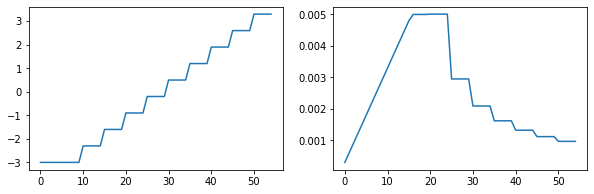

In [22]:
fig, axs = plt.subplots(1,2, figsize=(10, 3))
axs[0].plot(range(len(optimizerL.log['c'])), np.log10(optimizerL.log['c']))
axs[1].plot(range(len(optimizerL.log['lr'])), optimizerL.log['lr'])

In [23]:
def threshold(adj, threshold):
    return nn.Threshold(threshold, 0.0)(adj)-nn.Threshold(threshold, 0.0)(-adj)

def time_scores(adj):
    n_nodes = adj.shape[0]
    I = torch.eye(n_nodes).double()
    expA = torch.matrix_power(I+(1/n_nodes)*torch.tanh(adj)**2, n_nodes)
    scores = torch.div(1.0, torch.sum(expA, dim=1))-torch.div(1.0, torch.sum(expA, dim=0))
    return scores

testdata = iter(data_graph_gen(g, 30, 60))

In [24]:
batch = next(testdata)
preds, z_train, origin_A = autoencoder(batch.src.float(), batch.tgt.float())

In [25]:
threshold(preds[:1],0.1)
threshold(batch.src.float()[:1], 0.)

tensor([[[-0.4302,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.1835,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.5552,  0.0000,  0.1553],
         [ 0.2012, -0.2138,  0.0000, -1.9856,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -3.0806]]],
       grad_fn=<SubBackward0>)

tensor([[[-0.4071,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.2980,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.5741,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -2.2069,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -3.2560]]])

In [26]:
blah

NameError: name 'blah' is not defined

In [ ]:
mask_norm = F.softmax(-torch.exp(-(torch.abs(autoencoder.d_mask)+1e-10).log()), dim = -1)

autoencoder.d_mask
autoencoder.e_mask
threshold(mask_norm, 0.1)

optimizerL.constraint(mask_norm.squeeze())

In [ ]:
testt2 = torch.Tensor([[ 2.6456e-06, -9.5818e-08, -8.6945e-01,  2.0426e-02,  5.9849e-03],
        [-1.0854e-07,  2.3277e-06,  2.6204e-02, -5.4377e-01, -1.4878e+00],
        [-1.7013e-05,  2.5015e-09,  2.7552e-06, -1.5096e+00,  3.8229e-02],
        [ 2.6729e-05, -1.0530e-05, -2.9288e-05,  2.4118e-06,  1.2162e+00],
        [ 3.2156e-05, -4.2439e-05, -3.4324e-05,  2.3741e-05,  2.5642e-06]])

In [ ]:
-torch.exp(-(torch.abs(testt2+1e-10).log()))
F.softmax(-torch.exp(-(torch.abs(testt2)+1e-10).log()), dim = -1)

In [ ]:
torch.exp(-torch.exp(-(torch.abs(testt2)+1e-10).log()))

In [ ]:
-torch.exp(-(torch.abs(testt2)+1e-10).log())

In [ ]:
-1/(torch.abs(testt2)+1e-10)

In [ ]:
torch.abs(testt2)

In [ ]:
threshold(testt2, 0.1)
threshold(-torch.exp(-(torch.abs(testt2)+1e-10).log()), 0.1)
threshold(F.softmax(-torch.exp(-(torch.abs(testt2)+1e-10).log()), dim = -1), 0.1)
threshold(torch.exp(-torch.exp(-(torch.abs(testt2)+1e-10).log())), 0.1)

In [ ]:
# -torch.exp(-(torch.eye(autoencoder.d_mask.shape[1])+1e-10).log())
# -torch.exp(-5*(torch.abs(autoencoder.d_mask)+1e-4).log())

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
draw(torch.abs(autoencoder.d_mask.detach().squeeze()), list(range(5)), list(range(5)) if n_heads ==0 else [], ax=axs[0])
draw(torch.abs(mask_norm.detach().squeeze()), list(range(5)), list(range(5)) if n_heads ==0 else [], ax=axs[1])
plt.show()

In [ ]:
g.draw_graph()

In [ ]:
time_scores(mask_norm.squeeze().transpose(0,1))
torch.argsort(time_scores(mask_norm.squeeze().transpose(0,1)))

In [ ]:
# sent = list(range(5))
# tgt_sent = list(range(5))

# autoencoder.decoder.layers[0].self_attn.attn[0, 1].data

# for layer in range(0,2):
#     fig, axs = plt.subplots(1,2, figsize=(10, 10))
#     print("Decoder Self Layer", layer+1)
#     for h in range(2):
#         draw(autoencoder.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
#             tgt_sent[:-1], tgt_sent[:-1] if h ==0 else [], ax=axs[h])
#     plt.show()
#     print("Decoder Src Layer", layer+1)
#     fig, axs = plt.subplots(1,2, figsize=(10, 10))
#     for h in range(2):
#         draw(autoencoder.decoder.layers[layer].src_attn.attn[0, h].data[:len(tgt_sent)+1, :len(sent)+1], 
#             sent, tgt_sent if h ==0 else [], ax=axs[h])
#     plt.show()
# pass;

In [ ]:
blah

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

class KLSimple(nn.Module):
    "KL Loss"
    def __init__(self, generator, opt=None):
        super(KLSimple, self).__init__()
        self.generator = generator
#         self.criterion = nn.KLDivLoss(reduction='sum')
        self.criterion = LagrangeLoss.nll_gauss
        self.opt = opt
        
    def __call__(self, mask, memory, x, y, norm):
        loss = 0.1*torch.sum(torch.abs(mask)) + self.criterion(x, y, 0.0)/norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()

        return loss.data.item()*norm

In [ ]:
def run_graph_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out, memory, mask = model.forward(batch.src.float(), batch.tgt.float())
        loss = loss_compute(mask, memory, out, batch.tgt_y.float(), batch.ntokens)
#         print(loss.item(), total_tokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

# Train the simple copy task.
n_nodes=5
d_embed = 10
d_hidden=4*d_embed

n_layers= 4
n_heads = 2
dropout=0.1

model = EncoderDecoder(n_nodes, d_embed, d_hidden, n_layers, n_heads, dropout)
model_opt = NoamOpt(d_embed, 1, 400, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
lossKL = KLSimple(model.generator, model_opt)

for epoch in range(5):
    model.train()
    run_graph_epoch(data_graph_gen(g, 30, 60), model, lossKL)
    model.eval()
    eval_results = run_graph_epoch(data_graph_gen(g, 30, 5), model, KLSimple(model.generator, None))
    print("Results: %s"%eval_results)
pass;

In [ ]:
testdata = iter(data_graph_gen(g, 100, 60))

In [ ]:
batch = next(testdata)
preds, z_train, mask = model.forward(batch.src.float(), batch.tgt.float())
preds[:1]
batch.tgt_y[:1]

In [ ]:
# batch = next(testdata)
# preds, z_train, mask = model.forward(batch.src.float(), batch.tgt.float())
# test_loss = nn.KLDivLoss(reduction='sum')

# lossKL(mask, z_train, preds, batch.tgt_y.float(), batch.ntokens)
# test_loss(preds[:1], batch.tgt_y[:1])+0.1*torch.sum(torch.abs(mask))
# 0.1*torch.sum(torch.abs(mask))

In [ ]:
sent = list(range(batch.src.shape[1]))
tgt_sent = list(range(preds.shape[1]))

fig, axs = plt.subplots(1,1, figsize=(5, 5))
draw(20*mask.detach().squeeze(), tgt_sent[:-1], tgt_sent[:-1] if n_heads ==0 else [], ax=axs)
model.decoder.mask
plt.show()

In [ ]:
model.decoder.layers[0].self_attn.attn[0, 1].data

for layer in range(0,2):
    fig, axs = plt.subplots(1,2, figsize=(10, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(2):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent[:-1], tgt_sent[:-1] if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,2, figsize=(10, 10))
    for h in range(2):
        draw(model.decoder.layers[layer].src_attn.attn[0, h].data[:len(tgt_sent)+1, :len(sent)+1], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
pass;

In [ ]:
blah

## SEM Evaluation

In [ ]:
encoder.eval()
decoder.eval()

data = next(iter(test_loader))[0].double()
_, noise, _, _, _, _, Wa_train = encoder(data)
_, preds = decoder(noise, g_learned.torch_graph(), Wa_train)

In [ ]:
Wa_train

In [ ]:
X_train = NodeData(g.data, bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [ ]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

In [ ]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [ ]:
_, preds_resampled_cdf = decoder(g_learned.torch_data(Z_resampled_cdf.data()), g_learned.torch_graph(), Wa_train)
_, preds_resampled_pdf = decoder(g_learned.torch_data(Z_resampled_pdf.data()), g_learned.torch_graph(), Wa_train)
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=15)
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=15)

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

In [ ]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pX_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [ ]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [ ]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

## Graph Mutilation Tests

In [ ]:
g_mutil = spacetime_mutilator(g, mutilate=[mutilate])
g_mutil.data = Simulator.sem(graph=g_mutil.graph, n=10000, x_dims=args.x_dims, 
                             sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                             noise_scale=args.noise_scale, seed=args.seed)

In [ ]:
g_learned.draw_graph()

g_learned_mutil = spacetime_mutilator(g_learned, mutilate=[mutilate])
g_learned_mutil.draw_graph()

In [ ]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [ ]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

In [ ]:
_, preds_resampled_mutil_cdf = decoder(g_learned_mutil.torch_data(Z_resampled_mutil_cdf.data()), 
                                       g_learned_mutil.torch_graph(), Wa_train)
_, preds_resampled_mutil_pdf = decoder(g_learned_mutil.torch_data(Z_resampled_mutil_pdf.data()), 
                                       g_learned_mutil.torch_graph(), Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

In [ ]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

In [ ]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

In [ ]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

In [ ]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;